### Import libraries

In [1]:
import csv
#from optparse import OptionParser
from matplotlib import pyplot as plt
import numpy as np
from scipy import random
import pandas as pd
from numpy.linalg import pinv
from numpy.linalg import inv
random.seed(0)
import tensorflow as tf

### Set hyper-parameters for the dataset

In [2]:
numLags = 100
predictionStep = 3

### Read dataset

In [3]:
dataSet = '../nyc_taxi'
filePath = dataSet+'.csv'
df = pd.read_csv(filePath, header=0, skiprows=[1,2], names=['time', 'data', 'timeofday', 'dayofweek'])
df.head(5)

,time,data,timeofday,dayofweek
0,2014-07-01 00:00:00,10844,0,1
1,2014-07-01 00:30:00,8127,30,1
2,2014-07-01 01:00:00,6210,60,1
3,2014-07-01 01:30:00,4656,90,1
4,2014-07-01 02:00:00,3820,120,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
time         17520 non-null object
data         17520 non-null int64
timeofday    17520 non-null int64
dayofweek    17520 non-null int64
dtypes: int64(3), object(1)
memory usage: 547.6+ KB


In [5]:
df.isnull().sum()

time         0
data         0
timeofday    0
dayofweek    0
dtype: int64

In [6]:
  # standardize data by subtracting mean and dividing by std
  meanSeq = np.mean(df['data'])
  stdSeq = np.std(df['data'])
  df['data'] = (df['data'] - meanSeq)/stdSeq

### Prepare input-target pairs 

In [7]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['data'][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep)

generate time embedded matrix
input shape:  (17520, 100)
target shape:  (17520, 1)


In [8]:
print(X.shape, T.shape)

(17520, 100) (17520, 1)


# AUTOELM

In [9]:
weights = np.random.random((25,100))
print('weights:',weights.shape)

bias = np.random.random((1,25)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,100))
print('input features:', features.shape)

def linear(features,weights,bias):
    print(np.dot(features, np.transpose(weights))  + bias)
    return np.dot(features, np.transpose(weights)) #+ bias

hidden = linear(features,weights,bias)
print('hidden (before nonlinear activation):', hidden.shape)

def sigmoidActFunc(features):
  return 1.0 / (1.0 + np.exp(-features))

hidden = sigmoidActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)

def reluActFunc(features):
  return np.maximum(0,features)
hidden = reluActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)


weights: (25, 100)
bias: (1, 25)
input features: (1, 100)
[[26.73015071 27.98622253 29.20842738 25.69226713 29.06920576 25.30993178
  24.07201064 24.31074231 28.16047585 27.52178154 27.86130065 28.58902652
  27.49881974 29.0730478  26.64207791 29.25626895 28.32753515 24.11616073
  27.50254857 25.18363982 24.77184242 26.32346954 28.48496744 27.26313313
  25.02408901]]
hidden (before nonlinear activation): (1, 25)
hidden (after nonlinear activateion): (1, 25)
hidden (after nonlinear activateion): (1, 25)


In [10]:
nDimInput = 100
nDimOutput = 100
numNeurons = 25
lamb=0.0001
outputWeightFF = 0.92 

In [11]:
# comment these two lines when you want to alter things
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.2)
border = int(9999 * numNeurons)
x_train_init = X_train[:border] # it was 6250 before
x_train_seq = X_train[border:] # was 7766 before

print('total initial: ', (border))
print('total sequential: ', len(x_train_seq))

total initial:  249975
total sequential:  0


## AUTOELM implementation

In [12]:
from sklearn.metrics import mean_squared_error
class AUTOELM(object):

    def __init__(self, inputs, outputs, numHiddenNeurons, forgettingFactor=0.999):
        self.name = 'AUTOELM'
        self.inputs = inputs
        self.outputs = outputs
        self.numHiddenNeurons = numHiddenNeurons

        # input to hidden weights
        self.inputWeights = None
        # bias of hidden units
        self.bias = None
        # hidden to output layer connection
        self.beta = None
        # auxiliary matrix used for sequential learning
        self.M = None

        self.forgettingFactor = forgettingFactor
        self.bf= None
        self.k = None
        self.mask = None

    def calculateHiddenLayerActivation(self, features):
        print('features',features.shape,'wieghts',self.inputWeights,'bias',self.bias)
        V = (np.dot(features, np.transpose(self.inputWeights))  + self.bias)
        #H = sigmoidActFunc(V)
        print(V)
        H = reluActFunc(V)
        print(H.shape,H)
        return H


    def initializePhase(self, lamb=0.0001):
        """
        Step 1: Initialization phase
        """
        # randomly initialize the input->hidden connections
        self.inputWeights = np.random.random((self.inputs, self.numHiddenNeurons))
        self.bf = np.random.random()
        self.inputWeights = self.inputWeights * 2 - 1
        self.bias = np.random.random((self.numHiddenNeurons)) * 2 - 1
        # auxiliary matrix used for sequential learning
        self.M = inv(lamb*np.eye(self.numHiddenNeurons))
        # hidden to output layer connection
        self.beta = np.zeros([self.numHiddenNeurons,self.outputs])
        self.k = np.zeros([self.numHiddenNeurons,self.numHiddenNeurons])
    
    def init_training(self , features, targets):
        H = np.dot(self.inputs, self.inputWeights) + self.bias
        H = 1/(1+np.exp(-H)) # sigmoid activation function
        HT = np.transpose(H)
        I = np.identity(self.numHiddenNeurons)
        C_I = I
        HTH = np.dot(HT, H)
        K = C_I + HTH
        self.k = K
        inverse_k = np.linalg.inv(K)
        H_inverse = np.dot(inverse_k,HT)
        sin_y = np.sin(self.outputs)
        arcsin_y = np.arcsin(sin_y)
        inverse_acti_y = arcsin_y
        An = np.dot(H_inverse, inverse_acti_y)
        AnHf = np.dot(H,An)
        #Bn = mean_squared_error(AnHf,inverse_acti_y)
        Bn = np.square(np.subtract(AnHf,inverse_acti_y)).mean() 
        Bn = np.sqrt(Bn)
        self.beta = An
        init_train = Bn
        print("init training complete!")
        return init_train
    
    def seq_train(self, features, targets, mask):
        self.inputWeights = np.transpose(self.beta)  # assigns beta weights to alpha 
        H = np.dot(features, self.inputWeights) + self.bf
        H = 1/(1+np.exp(-H))
        HT = np.transpose(H)
        HTH = np.dot(HT, H)
        K = self.k + HTH
        self.k = K
        #addition
        K_dirty = K + 0.00001*np.random.rand(25, 25)
        # * #
        K_inverse = np.linalg.inv(K_dirty)
        sin_y = np.sin(self.outputs)
        arcsin_y = np.arcsin(sin_y)
        inverse_acti_y = arcsin_y
        UPDATE = np.dot(np.dot(K_inverse, HT), inverse_acti_y - np.dot(H, self.beta))  # [D x m]    
        ###############################multiplication with mask  makes it zero ############3
        #UPDATE = np.dot(mask, UPDATE)
        ###############################multiplication with mask  makes it zero ############3
        An = self.beta + UPDATE
        self.beta = An
        AnHf = np.dot(H, An)
        Bn = np.square(np.subtract(AnHf,inverse_acti_y)).mean() 
        Bn = np.sqrt(Bn)
        self.bf = Bn
        seq_train =  Bn
        return seq_train
    
    def retrieve_beta(self):
        return self.beta
    
    def predict(self, features):
        """
        Make prediction with feature matrix
        :param features: feature matrix with dimension (numSamples, numInputs)
        :return: predictions with dimension (numSamples, numOutputs)
        """
       # tf.matmul(self.__activation(tf.matmul(self.__x, self.inputWeights) + self.__bf), self.__beta)
        H = (np.dot(features,self.inputWeights) + self.bf)
        H = 1/(1+np.exp(-H))
        H = np.dot(H,self.beta)
        prediction = H
        return prediction



In [13]:

def perform_sequential_training(train_set, auto_elm, epochs, x_seq_train, batch_size, h_nodes, number_neurons, flag):
    neuron = random.randint(0, h_nodes - 1) # select initial hidden neuron
    mask = np.zeros([h_nodes, h_nodes]) # mask of hidden neuron dimensions
    mask[neuron,neuron] = 1 # add a single digit to a row (corresponds to single neuron)
        # mask = np.eye(256) # update all nodes
    group = 1 # group of images
    count = train_set # number of training images

        # actual network training phase
    for epoch in range(epochs):
        for i in range(0, len(x_seq_train), batch_size):
            x_batch = x_seq_train[i:i+batch_size]
            auto_elm.seq_train(x_batch, x_batch, mask)
        
        # fetch the node beta weight data
        node = auto_elm.retrieve_beta()[neuron]
    
    print("Neuron Used: {}\n".format(neuron))
    print("sequential training complete!")
    return node

# added for beta weight

In [14]:
auto_elm = AUTOELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=outputWeightFF)
auto_elm.initializePhase(lamb=lamb)
encoding_0 = auto_elm.init_training(x_train_init,x_train_init)
decoding_0 = perform_sequential_training(10,auto_elm,20,x_train_seq,50,numNeurons,0,False)

# Block added here for using Beta values to generate more training data
thr = 1200 * 12  # NB_YEARS * 12 (months)

x_train_temp1 = X[:thr]
y_train_temp1 = T[thr:]

x_test1 = X[:thr]
y_test1 = T[thr:]


nb_copies = 98
X_train_fake = np.concatenate([
    x_train_temp1
    + 5 * decoding_0 - 5  # global offset with a (possibly large) scalar
    + 2 * np.random.random(x_train_temp1.shape) - 1  # small element-wise offset
    for _ in range(nb_copies)
])
y_train_fake = np.concatenate([
    y_train_temp1
    for _ in range(nb_copies)
])


print('augmented data X shape',X_train_fake.shape, x_test1.shape)
print('augmented data Y shape',y_train_fake.shape, y_test1.shape)


init training complete!
Neuron Used: 13

sequential training complete!
augmented data X shape (1411200, 100) (14400, 100)
augmented data Y shape (305760, 1) (3120, 1)


In [15]:
from matplotlib import pyplot
print(X_train_fake.shape,y_train_fake.shape)

(1411200, 100) (305760, 1)


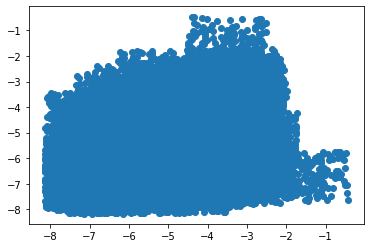

In [16]:
pyplot.scatter(X_train_fake[:,50],X_train_fake[:,99])
pyplot.show()

In [17]:
X_train_fake

array([[-4.33858799, -4.95754826, -5.80792702, ..., -5.3130586 ,
        -5.36585897, -4.06029657],
       [-5.79693473, -4.40958196, -5.16049077, ..., -5.19759485,
        -5.84507687, -5.74970345],
       [-4.2470216 , -5.90622475, -5.09618882, ..., -5.79187107,
        -5.19543995, -5.59907365],
       ...,
       [-2.88833576, -4.44770961, -3.34010372, ..., -5.85101442,
        -5.15106297, -6.00666212],
       [-3.78297217, -2.63196928, -3.35640777, ..., -5.52798815,
        -5.99770408, -5.70987868],
       [-3.89675758, -4.13294899, -3.90765896, ..., -4.6107011 ,
        -4.63416202, -5.04385437]])

In [18]:
X_train.shape

(14016, 100)

In [19]:
maxElement = np.amax(X_train)
maxElement

3.5362914891867696

# Defining GAN

In [20]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

Using TensorFlow backend.


In [21]:
def discriminator():
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim = 2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
def generator(latent_dim, outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(outputs, activation='linear'))
    return model

In [23]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss3
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
def GAN(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [26]:
X_train.shape

(14016, 100)

In [27]:
def generate_real_samples(n = 1401600):
    X1 = (X_train - 4) * -0.5
    X2 = np.sqrt(X1)
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X,y

In [28]:
X1,y1 = generate_real_samples()

In [29]:
X_train_fake

array([[-4.33858799, -4.95754826, -5.80792702, ..., -5.3130586 ,
        -5.36585897, -4.06029657],
       [-5.79693473, -4.40958196, -5.16049077, ..., -5.19759485,
        -5.84507687, -5.74970345],
       [-4.2470216 , -5.90622475, -5.09618882, ..., -5.79187107,
        -5.19543995, -5.59907365],
       ...,
       [-2.88833576, -4.44770961, -3.34010372, ..., -5.85101442,
        -5.15106297, -6.00666212],
       [-3.78297217, -2.63196928, -3.35640777, ..., -5.52798815,
        -5.99770408, -5.70987868],
       [-3.89675758, -4.13294899, -3.90765896, ..., -4.6107011 ,
        -4.63416202, -5.04385437]])

In [30]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    #x_input = randn(len(X_train))
    # generate points in the latent space
    x_input = X_train_fake[:1401600]
    #x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((len(X), 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=1401600 ):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()


In [31]:
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 50

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [32]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
n_batch=1401600 
n_epochs = 5000
# size of the latent space
latent_dim = 100
#with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
for i in range(n_epochs):
    half_batch = int(n_batch)
    x_real, y_real = generate_real_samples(half_batch)
    print(x_real)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
    print(x_fake)
        #gen_loss = generator_loss(x_fake)
        #disc_loss = discriminator_loss(x_real, x_fake)

        #gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        #gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

[[1.74576409 1.32127366]
 [1.91553193 1.38402743]
 [2.00459407 1.41583688]
 ...
 [2.15889515 1.46931792]
 [2.31033745 1.51997942]
 [2.42718111 1.55794131]]


AttributeError: 'function' object has no attribute 'predict'

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=5000, n_batch=1401600 , n_eval=100):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = discriminator()
# create the generator
generator = generator(latent_dim)
# create the gan
gan_model = GAN(generator, discriminator)
# train model
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("training started" ,dt_string)
train(generator, discriminator, gan_model, latent_dim)
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("training ended" ,dt_string)